In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import joblib 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [4]:
data = pd.read_csv('/kaggle/input/fake-news-detection-using-machine-learning/News.csv')
data.head()

,Unnamed: 0,title,text,subject,date,class
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [5]:
data.shape

(44919, 6)

In [6]:
data = data.drop(["title", "subject","date"], axis = 1)

In [7]:
data.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

In [8]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

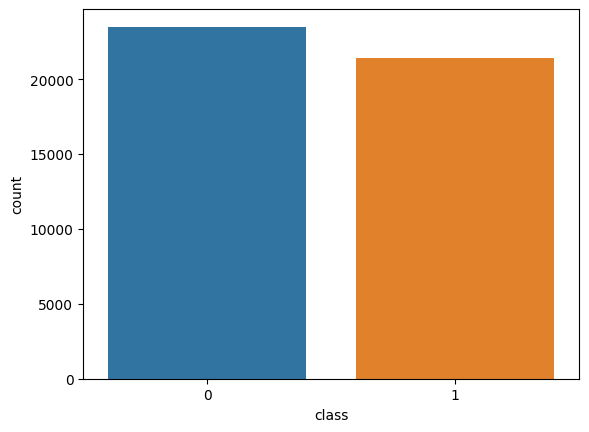

In [9]:
sns.countplot(data=data,x='class',order=data['class'].value_counts().index)

In [10]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

In [11]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [25:45<00:00, 29.07it/s]


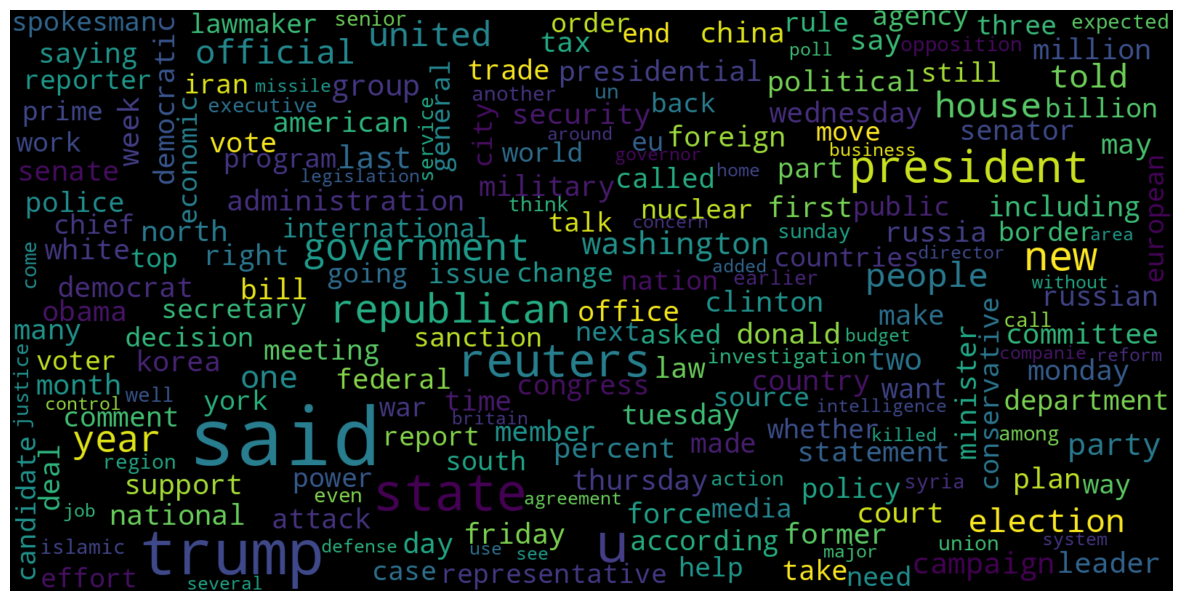

In [12]:
# Real
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

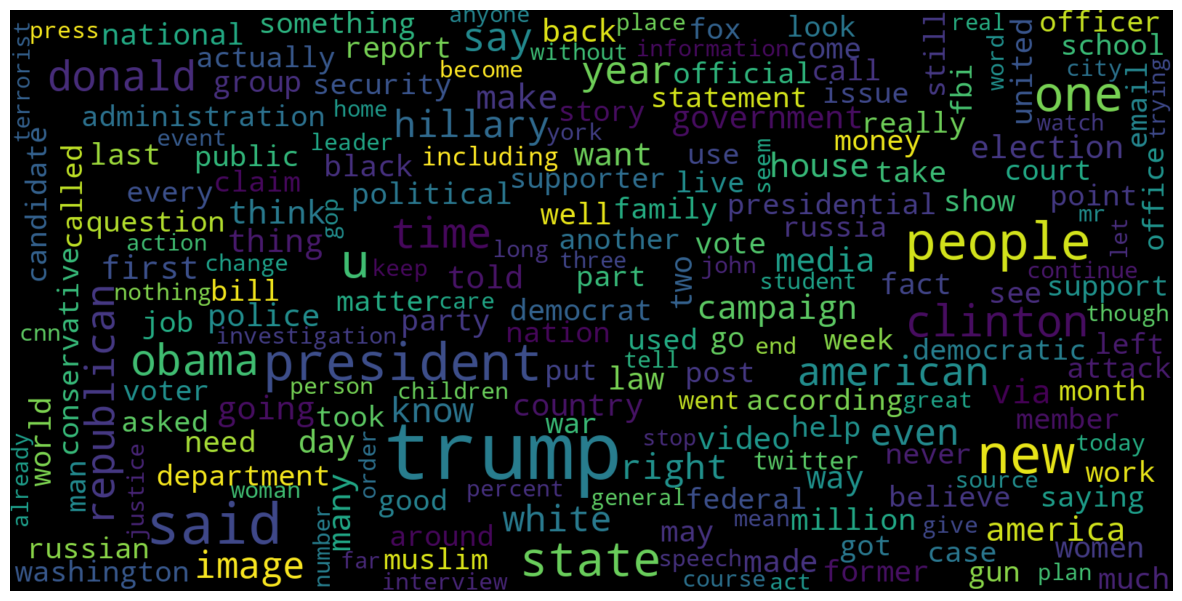

In [13]:
# Fake
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

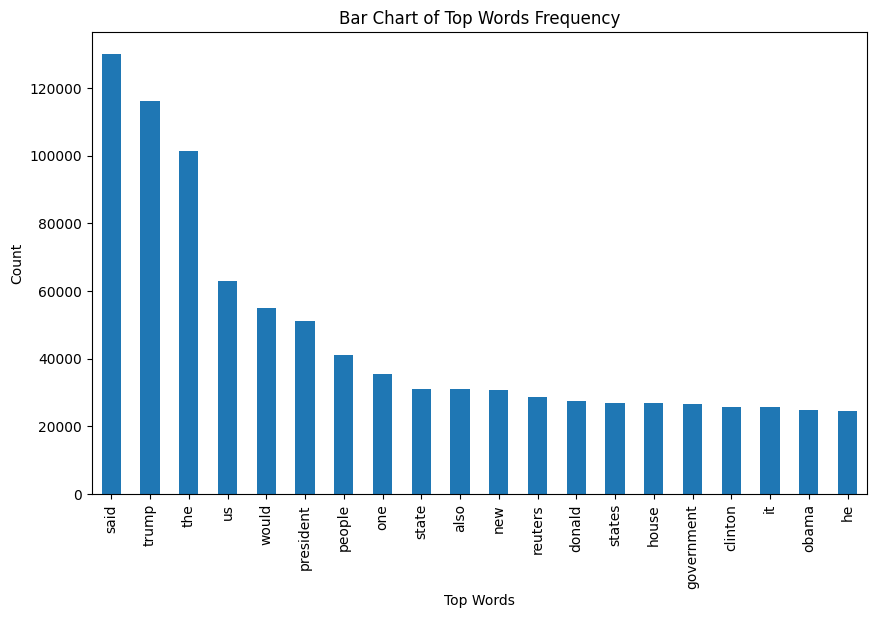

In [14]:
def get_top_n_words(corpus, n=None):
	vec = CountVectorizer().fit(corpus)
	bag_of_words = vec.transform(corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data['text'],
													data['class'],
													test_size=0.25)

In [16]:
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [17]:
Lmodel = LogisticRegression()
Lmodel.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, Lmodel.predict(x_train)))
print(accuracy_score(y_test, Lmodel.predict(x_test)))

0.9934993618094927
0.9889581478183437


In [18]:
Dmodel = DecisionTreeClassifier()
Dmodel.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, Dmodel.predict(x_train)))
print(accuracy_score(y_test, Dmodel.predict(x_test)))

0.9999703167205913
0.9970614425645592


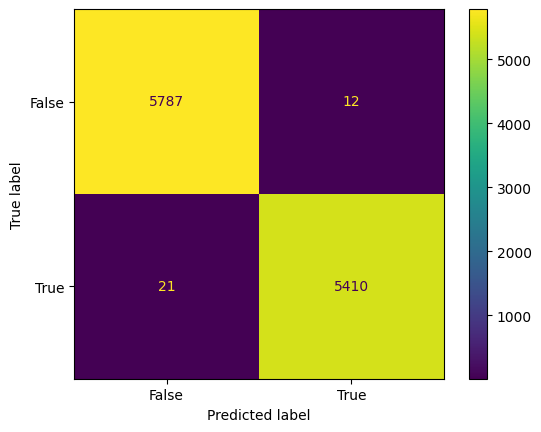

In [19]:
# Confusion matrix of Results from Decision Tree classification

cm = metrics.confusion_matrix(y_test, Dmodel.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()

In [20]:
joblib.dump(vectorization, 'Vectorizer.pkl')

['Vectorizer.pkl']

In [21]:
joblib.dump(Dmodel, 'DecisionTreeClassification.pkl')

['DecisionTreeClassification.pkl']

In [31]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

Vectorizer1 = joblib.load('Vectorizer.pkl')

Dmodel1 = joblib.load('DecisionTreeClassification.pkl')

In [34]:
def predict_from_text(raw_text_list):
    processed_text = preprocess_text(raw_text_list)         # Step 1: Clean text
    vectorized_text = Vectorizer1.transform(processed_text)  # Step 2: Vectorize
    predictions = Dmodel1.predict(vectorized_text)           # Step 3: Predict
    
    results = []
    for pred in predictions:
        label = "Real" if pred == 1 else "Fake"
        results.append(label)

    return results

In [38]:
texts = [
    # Real News
    "NASA announces successful launch of James Webb Space Telescope.",
    "21st Century Wire says This week s announcement by the CIA that they somehow  lost  the infamous torture report has failed to impress its critics who are all but certain that the agency has destroyed, or hidden the report in order to protect all who are involved in the illegal and ultimately useless practice of torturing alleged  terrorist  suspects in order to obtain made-up information.I worked @CIA. I wrote the Emergency Destruction Plan for Geneva. When CIA destroys something, it's never a mistake. https://t.co/S1VULfE4NY  Edward Snowden (@Snowden) May 18, 2016RTThe comprehensive Senate torture report could be what was needed to really drive the point home about America s use of torture and its true effectiveness. Word of the document being destroyed emerged despite Justice Department lawyers earlier assuring a federal court there were several copies in existence.The report was said to have been destroyed by the CIA inspector general s office in an  inadvertent  fashion. What was extremely peculiar was the fact that last summer the officials had uploaded a copy onto a computer, then accidentally deleted that. As if that wasn t enough, they have now accidentally destroyed the disk which contained the copy of the report. I worked @CIA. I wrote the Emergency Destruction Plan for Geneva,  Snowden told his millions of global supporters over Twitter.  When the CIA destroys something, it s never a mistake. Continue this story at RTREAD MORE SNOWDEN NEWS AT: 21st Century Wire Snowden Files",
    
    
    "NEW YORK (Reuters) - U.S. President-elect Donald Trump will meet with Lockheed Martin Corp Chief Executive officer Marillyn Hewson on Friday, a Trump transition officials said. Trump, who takes office next Friday, said last month he viewed costs for the aerospace companyâ€™s F-35 fighter as too high and would ask Boeing to price out an upgraded F-18.",
    "NEW YORK (Reuters) - Anthony Scaramucci, a hedge fund founder who was a fundraiser in Donald Trumpâ€™s election campaign, will join the president-electâ€™s White House staff as an advisor and public liaison to government agencies and businesses, he said on Friday. Scaramucci, founder of Skybridge Capital hedge fund and a former employee at Goldman Sachs(GS.N), is a member of Trumpâ€™s transition team. He will work as a liaison in the White House for state and local governments and for both American and foreign businesses, Scaramucci told reporters in New York. â€œOne of my other personal goals though is to get all of the American people to see President Trump the way I see him,â€ he added. Trump, a Republican, takes office on Jan. 20. Scaramucci played down media reports from Thursday that he would hold a position analogous to that currently held by Valerie Jarrett, who oversees the White Houseâ€™s Offices of Public Engagement and Intergovernmental Affairs and is seen as one of President Barack Obamaâ€™s most powerful advisers.  â€œThatâ€™s probably an overstatement,â€ Scaramucci said when asked about the comparison. â€œValerie and I know each other quite well and I will be speaking to her later in the day. I donâ€™t want to overstate the position.â€ Scaramucci did not discuss what would happen to Skybridge, which had $12 billion in assets under management or advisement as of Nov. 30, 2016, down from $12.9 billion as of Dec. 31, 2015, according to firmâ€™s website. The firm was put up for auction as Scaramucci began considering a potential position in the White House, Reuters reported last month."
]


preds = predict_from_text(texts)

for txt, pred in zip(texts, preds):
    print(f"Text: {txt}\n=> Prediction: {pred}\n")

100%|██████████| 4/4 [00:00<00:00, 78.23it/s]

Text: NASA announces successful launch of James Webb Space Telescope.
=> Prediction: Fake

Text: 21st Century Wire says This week s announcement by the CIA that they somehow  lost  the infamous torture report has failed to impress its critics who are all but certain that the agency has destroyed, or hidden the report in order to protect all who are involved in the illegal and ultimately useless practice of torturing alleged  terrorist  suspects in order to obtain made-up information.I worked @CIA. I wrote the Emergency Destruction Plan for Geneva. When CIA destroys something, it's never a mistake. https://t.co/S1VULfE4NY  Edward Snowden (@Snowden) May 18, 2016RTThe comprehensive Senate torture report could be what was needed to really drive the point home about America s use of torture and its true effectiveness. Word of the document being destroyed emerged despite Justice Department lawyers earlier assuring a federal court there were several copies in existence.The report was said to 